In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.max_rows = 8  
%matplotlib inline

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('data/SH600519.csv',header=0, index_col=0)  # 读取股票文件
maotai

,date,open,close,high,low,volume,code
74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
...,...,...,...,...,...,...,...
2496,2020-04-21,1221.020,1200.000,1223.990,1193.000,29224.00,600519
2497,2020-04-22,1206.000,1244.500,1249.500,1202.220,44035.00,600519
2498,2020-04-23,1250.000,1252.260,1265.680,1247.770,26899.00,600519
2499,2020-04-24,1248.000,1250.560,1259.890,1235.180,19122.00,600519


In [53]:
training_set = maotai.iloc[0:2426 - 300, 1:].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 1:].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

#为了方便可视化，对开盘价格单独进行归一化，后续可以进行反归一化
sc2 = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc2.fit_transform( maotai.iloc[0:2426 - 300, 2:3].values)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set2 = sc2.transform(maotai.iloc[2426 - 300:, 2:3].values)  # 利用训练集的属性对测试集进行归一化

array([[0.011711  , 0.00961659, 0.01084418, 0.01042639, 0.35355593,
        0.        ],
       [0.00980951, 0.0060261 , 0.00842889, 0.00658403, 0.18031668,
        0.        ],
       [0.00540518, 0.00528679, 0.00529619, 0.00503046, 0.06690898,
        0.        ],
       ...,
       [0.83272021, 0.83672993, 0.83904497, 0.83782707, 0.07708847,
        0.        ],
       [0.84059718, 0.84690772, 0.84899028, 0.84535127, 0.07648854,
        0.        ],
       [0.85205973, 0.84309105, 0.86176303, 0.85409366, 0.10174938,
        0.        ]])

array([[0.00961659],
       [0.0060261 ],
       [0.00528679],
       ...,
       [0.83672993],
       [0.84690772],
       [0.84309105]])

In [54]:
x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 1:]) #这里training_set_scaled仍然是二维数组，所以需要向里面添加一维数组
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
print("转化前的数据格式为：")
print(x_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，
#循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 5))
print("转化后训练集的数据格式为：")
print(x_train)

转化前的数据格式为：
[[[0.11873236 0.11793419 0.1128658  0.08420595 0.        ]
  [0.12234688 0.1229406  0.12245808 0.13654515 0.        ]
  [0.1255642  0.12449359 0.12322483 0.11311604 0.        ]
  ...
  [0.19086742 0.19870219 0.18467386 0.27795045 0.        ]
  [0.2038342  0.2052011  0.18930016 0.31440401 0.        ]
  [0.19709848 0.20790195 0.19745496 0.24995267 0.        ]]

 [[0.98126863 0.99646358 0.99070153 0.14742548 0.        ]
  [0.97460501 0.98897295 0.98589607 0.11262971 0.        ]
  [0.97039678 0.97558828 0.97331992 0.09768833 0.        ]
  ...
  [0.85765094 0.85236634 0.83398615 0.14404246 0.        ]
  [0.84874538 0.8614817  0.85770528 0.08892017 0.        ]
  [0.85560125 0.85458891 0.85849353 0.07087266 0.        ]]

 [[0.10696712 0.10742058 0.10568414 0.1863533  0.        ]
  [0.11018443 0.11063346 0.10865368 0.19473808 0.        ]
  [0.11547971 0.11793419 0.1126107  0.19854708 0.        ]
  ...
  [0.18630579 0.18450726 0.17761401 0.14269706 0.        ]
  [0.19100029 0.1961926

In [55]:
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 1:])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 5))

In [59]:
model = tf.keras.Sequential([
    LSTM(50, return_sequences=True), #第一层记忆体的个数为50个，每个时间步推送ht到下一层
    Dropout(0.2),
    LSTM(60),  #第二层
    Dropout(0.2),
    Dense(1) #输出知识ht+1的股票开盘价，所以是1
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/LSTM_stock.ckpt"

# if os.path.exists(checkpoint_save_path + '.index'):
#     print('-------------load the model-----------------')
#     model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()


Epoch 1/10
33/33 [==============================] - 2s 65ms/step - loss: 0.0216 - val_loss: 0.0121
Epoch 2/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0021 - val_loss: 0.0558
Epoch 3/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0020 - val_loss: 0.0425
Epoch 4/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0017 - val_loss: 0.0564
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0020 - val_loss: 0.0374
Epoch 6/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0014 - val_loss: 0.0231
Epoch 7/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0015 - val_loss: 0.0314
Epoch 8/10
33/33 [==============================] - 1s 43ms/step - loss: 0.0014 - val_loss: 0.0275
Epoch 9/10
33/33 [==============================] - 1s 42ms/step - loss: 0.0014 - val_loss: 0.0433
Epoch 10/10
33/33 [==============================] - 2s 51ms/step - loss: 0.0013 - val_loss: 0.0090
Model: "s

30

9

12318

40

10

491

28

7

3251

30

10

491

40

10

492

28

7

3901

17

8

901

15

5

13

Text(0.5, 1.0, 'Training and Validation Loss')

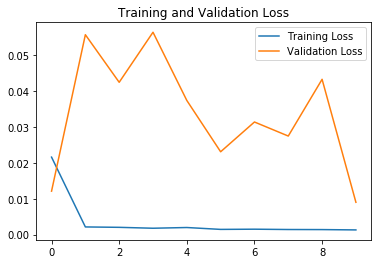

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
print(x_test)

[[[0.84288404 0.8543997  0.85335102 0.84258523 0.08130216 0.        ]
  [0.85345726 0.84167747 0.85084711 0.85405067 0.05417054 0.        ]
  [0.84641315 0.86090218 0.85560173 0.85628643 0.103858   0.        ]
  ...
  [1.2223339  1.22193087 1.23580226 1.23957612 0.12721965 0.        ]
  [1.22049876 1.26005516 1.27676512 1.22524432 0.16021565 0.        ]
  [1.25296657 1.26292473 1.27108208 1.26553101 0.10118495 0.        ]]

 [[0.85345726 0.84167747 0.85084711 0.85405067 0.05417054 0.        ]
  [0.84641315 0.86090218 0.85560173 0.85628643 0.103858   0.        ]
  [0.87046756 0.86524187 0.86882462 0.87355625 0.08193403 0.        ]
  ...
  [1.22049876 1.26005516 1.27676512 1.22524432 0.16021565 0.        ]
  [1.25296657 1.26292473 1.27108208 1.26553101 0.10118495 0.        ]
  [1.19297171 1.16680119 1.20080378 1.16505076 0.45317532 0.        ]]

 [[0.84641315 0.86090218 0.85560173 0.85628643 0.103858   0.        ]
  [0.87046756 0.86524187 0.86882462 0.87355625 0.08193403 0.        ]
  [0

Text(0.5, 1.0, 'MaoTai Stock Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'MaoTai Stock Price')

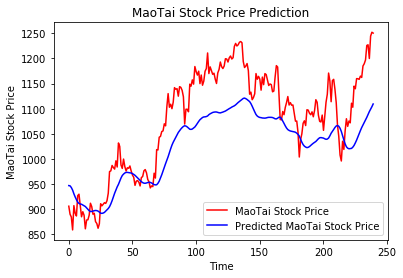

均方误差: 4953.677815
均方根误差: 70.382369
平均绝对误差: 59.612014


In [61]:
################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)

# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc2.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc2.inverse_transform(test_set2[60:])

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)